#Initial Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, random, torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
data_src = 'solar_data_combined_cleaned.csv'
data_df = pd.read_csv(data_src)

In [3]:
data_df

,datetime,local_datetime,Year,Month,Day,Hour,Minute,Temperature,Alpha,AOD,...,Ozone,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Kcs
0,2018-01-01 16:30:00,2018-01-01 09:30:00,2018,1,1,16,30,-1.2,1.20,0.021,...,0.347,34.07,72.17,0.91,0.13,830,0.4,254,1.1,0.451
1,2018-01-01 16:40:00,2018-01-01 09:40:00,2018,1,1,16,40,-0.8,1.20,0.021,...,0.347,34.81,71.05,0.91,0.13,829,0.4,257,0.9,0.561
2,2018-01-01 16:50:00,2018-01-01 09:50:00,2018,1,1,16,50,-0.3,1.20,0.021,...,0.346,33.56,69.98,0.91,0.13,829,0.4,259,0.7,0.568
3,2018-01-01 17:00:00,2018-01-01 10:00:00,2018,1,1,17,0,0.1,1.20,0.021,...,0.346,32.60,68.98,0.91,0.13,829,0.4,262,0.5,0.596
4,2018-01-01 17:10:00,2018-01-01 10:10:00,2018,1,1,17,10,0.5,1.20,0.021,...,0.345,31.68,68.04,0.91,0.13,829,0.4,219,0.5,0.607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135551,2023-12-31 22:00:00,2023-12-31 15:00:00,2023,12,31,22,0,3.1,1.15,0.029,...,0.326,57.39,75.10,0.86,0.12,827,0.7,71,0.6,0.822
135552,2023-12-31 22:10:00,2023-12-31 15:10:00,2023,12,31,22,10,2.8,1.15,0.029,...,0.326,58.62,76.39,0.86,0.12,827,0.7,74,0.6,0.824
135553,2023-12-31 22:20:00,2023-12-31 15:20:00,2023,12,31,22,20,2.5,1.15,0.029,...,0.327,59.88,77.74,0.87,0.12,827,0.7,77,0.5,0.781
135554,2023-12-31 22:30:00,2023-12-31 15:30:00,2023,12,31,22,30,2.2,1.15,0.029,...,0.327,61.17,79.12,0.87,0.12,827,0.7,80,0.5,0.735


In [4]:
from copy import deepcopy as dc

data = dc(data_df)
data['local_datetime'] = pd.to_datetime(data_df['local_datetime'], errors='coerce')
data.dropna(subset=['local_datetime'], inplace=True)
data.set_index('local_datetime', inplace = True)
data.drop('datetime', axis = 1, inplace = True)
data['Target'] = data['GHI'].shift(-6)
data.dropna(inplace = True)

In [5]:
data

,Year,Month,Day,Hour,Minute,Temperature,Alpha,AOD,Asymmetry,Clearsky DHI,...,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Kcs,Target
local_datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 09:30:00,2018,1,1,16,30,-1.2,1.20,0.021,0.62,46,...,34.07,72.17,0.91,0.13,830,0.4,254,1.1,0.451,251.0
2018-01-01 09:40:00,2018,1,1,16,40,-0.8,1.20,0.021,0.62,47,...,34.81,71.05,0.91,0.13,829,0.4,257,0.9,0.561,273.0
2018-01-01 09:50:00,2018,1,1,16,50,-0.3,1.20,0.021,0.62,48,...,33.56,69.98,0.91,0.13,829,0.4,259,0.7,0.568,283.0
2018-01-01 10:00:00,2018,1,1,17,0,0.1,1.20,0.021,0.62,49,...,32.60,68.98,0.91,0.13,829,0.4,262,0.5,0.596,323.0
2018-01-01 10:10:00,2018,1,1,17,10,0.5,1.20,0.021,0.62,50,...,31.68,68.04,0.91,0.13,829,0.4,219,0.5,0.607,326.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 14:00:00,2023,12,31,21,0,4.9,1.16,0.029,0.62,52,...,44.88,68.45,0.86,0.12,827,0.6,43,1.3,0.743,203.0
2023-12-31 14:10:00,2023,12,31,21,10,4.6,1.16,0.029,0.62,51,...,45.82,69.41,0.86,0.12,827,0.6,47,1.2,0.666,183.0
2023-12-31 14:20:00,2023,12,31,21,20,4.3,1.16,0.029,0.62,50,...,46.80,70.43,0.86,0.12,827,0.6,52,1.1,0.795,153.0


In [6]:
trainSet = data[['Hour', 'Temperature', 'Pressure', 'DHI', 'Clearsky DNI', 'GHI', 'Clearsky GHI', 'DNI', 'Relative Humidity', 'SSA', 'Pressure', 'Solar Zenith Angle', 'Kcs', 'Target']]

In [7]:
trainSet

,Hour,Temperature,Pressure,DHI,Clearsky DNI,GHI,Clearsky GHI,DNI,Relative Humidity,SSA,Pressure,Solar Zenith Angle,Kcs,Target
local_datetime,,,,,,,,,,,,,,
2018-01-01 09:30:00,16,-1.2,830,133,878,142,315,27,34.07,0.91,830,72.17,0.451,251.0
2018-01-01 09:40:00,16,-0.8,829,161,894,189,337,85,34.81,0.91,829,71.05,0.561,273.0
2018-01-01 09:50:00,16,-0.3,829,171,907,204,359,95,33.56,0.91,829,69.98,0.568,283.0
2018-01-01 10:00:00,17,0.1,829,185,919,226,379,115,32.60,0.91,829,68.98,0.596,323.0
2018-01-01 10:10:00,17,0.5,829,198,929,241,397,114,31.68,0.91,829,68.04,0.607,326.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 14:00:00,21,4.9,827,183,894,283,381,270,44.88,0.86,827,68.45,0.743,203.0
2023-12-31 14:10:00,21,4.6,827,170,882,241,362,203,45.82,0.86,827,69.41,0.666,183.0
2023-12-31 14:20:00,21,4.3,827,142,869,271,341,385,46.80,0.86,827,70.43,0.795,153.0


#Data Handling Utility Functions

In [8]:
def create_3D_sequences(data, timesteps):
    """
    Create 3D sequences from the given data based on specific timesteps.

    Parameters:
        data (DataFrame): The input data including the target column.
        timesteps (list): A list of specific timesteps to include in each sequence.

    Returns:
        X (numpy array): 3D array of input sequences.
        Y (numpy array): Target values corresponding to each sequence.
    """
    X = []
    Y = []
    data_np = data.drop('Target', axis=1).to_numpy()  # Exclude 'Target' from X
    target_np = data['Target'].to_numpy()             # Isolate 'Target'

    max_timestep = max(timesteps)  # Get the largest timestep for proper slicing

    for i in range(len(data_np) - max_timestep):
        X.append(data_np[i + np.array(timesteps)])  # Select only the specified timesteps
        Y.append(target_np[i + max_timestep])  # Predict the value after the last timestep

    return np.array(X), np.array(Y)

In [9]:
def data_split_scale(X, Y):
  train = int(0.8 * len(X))  # 80% Train
  test = len(X) - train #20% test

  X_train, Y_train = X[:train], Y[:train]
  X_test, Y_test = X[train:], Y[train:]

  X_scaler = MinMaxScaler(feature_range=(-1,1))
  Y_scaler = MinMaxScaler(feature_range=(-1,1))

  #Flattening Dataset For Scaling

  X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
  X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

  X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
  X_test_scaled = X_scaler.transform(X_test_reshaped)

  #Reshaping Back Into 3D Dataset

  X_train_scaled = X_train_scaled.reshape(X_train.shape)
  X_test_scaled = X_test_scaled.reshape(X_test.shape)

  Y_train_scaled = Y_scaler.fit_transform(Y_train.reshape(-1,1))
  Y_test_scaled = Y_scaler.transform(Y_test.reshape(-1,1))

  print("Shapes: ", X_train_scaled.shape, Y_train_scaled.shape, X_test_scaled.shape, Y_test_scaled.shape)

  return X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, X_scaler, Y_scaler

In [10]:
class TimeSeriesData(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.Y[i]

In [11]:
def data_handler(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, batch_size = 256):
  X_train_tensor = torch.tensor(X_train_scaled, dtype = torch.float32).to(device)
  Y_train_tensor = torch.tensor(Y_train_scaled, dtype = torch.float32).to(device)
  X_test_tensor = torch.tensor(X_test_scaled, dtype = torch.float32).to(device)
  Y_test_tensor = torch.tensor(Y_test_scaled, dtype = torch.float32).to(device)
  train_dataset = TimeSeriesData(X_train_tensor, Y_train_tensor)
  test_dataset = TimeSeriesData(X_test_tensor, Y_test_tensor)
  train_loader = DataLoader(train_dataset, batch_size, shuffle = False)
  test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

  return X_train_tensor, X_test_tensor, Y_train_tensor, Y_test_tensor, train_dataset, test_dataset, train_loader, test_loader

#LSTM Configuration

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
      batch_size = x.size(0)
      h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
      c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
      lstm_out, (h_n, _) = self.lstm(x, (h0, c0))
      #lstm_out, _ = self.lstm(x)
      return self.fc(lstm_out[:, -1, :])

#Linear LSTM Built

In [22]:
def initialize_model(input_size, neurons, num_layers = 1, learning_rate = 1e-3):
  model = LSTMModel(input_size=input_size, hidden_size=neurons, num_layers=num_layers).to(device)
  criterion = nn.SmoothL1Loss(beta=1.0)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, min_lr = 1e-5, threshold = 0.001)
  return model, criterion, optimizer, scheduler

In [23]:
def train_epoch(model, optimizer, criterion, train_loader):
  model.train(True)
  train_loss = 0

  for batch_idx, (batch_X, batch_Y) in enumerate(train_loader):
      batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

      optimizer.zero_grad()
      outputs = model(batch_X)
      loss = criterion(outputs, batch_Y)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() #Use Detach Function

  avg_train_loss = train_loss / len(train_loader)
  return avg_train_loss

In [24]:
def val_epoch(model, criterion, scheduler, val_loader):
  model.eval()
  val_loss = 0
  with torch.no_grad():
      for batch_idx, (batch_X, batch_Y) in enumerate(val_loader):
          batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
          outputs = model(batch_X)
          loss = criterion(outputs, batch_Y)
          val_loss += loss.item()

  avg_val_loss = val_loss / len(val_loader)
  scheduler.step(avg_val_loss)
  return avg_val_loss

In [25]:
def compute_error(model, X_test_tensor, Y_test_tensor, Y_scaler):
    model.eval()
    with torch.no_grad():
      outputs = model(X_test_tensor).cpu().numpy().flatten()
      outputs = Y_scaler.inverse_transform(outputs.reshape(-1, 1)).flatten()

      actual = Y_test_tensor.cpu().numpy().flatten()
      actual = Y_scaler.inverse_transform(actual.reshape(-1, 1)).flatten()

    rmse = np.sqrt(mean_squared_error(actual, outputs))
    nrmse_mean = rmse / np.mean(actual)
    mae = mean_absolute_error(actual, outputs)
    return rmse, nrmse_mean, mae

In [26]:
class EarlyStopping:
    def __init__(self, patience, optimizer, min_delta = 1e-4):
        self.patience = patience
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.min_delta = min_delta
        self.min_lr = 1e-5
        self.optimizer = optimizer
        self.best_model_state = None

    def check(self, model, avg_val_loss):
        if (self.best_val_loss - avg_val_loss) > self.min_delta:
            self.best_val_loss = avg_val_loss
            self.patience_counter = 0
            self.best_model_state = model.state_dict()  # Save Ideal Model State
        else:
            self.patience_counter += 1
            current_lr = self.optimizer.param_groups[0]['lr']
            if self.patience_counter >= self.patience and current_lr <= self.min_lr:
                print("\n🛑 Early stopping triggered. Restoring best model...")
                model.load_state_dict(self.best_model_state)  # Restore best model
                return True  # Signal to Stop Training
        return False  # Continue Training

In [27]:
def run_model(model, epochs, scheduler, optimizer, criterion, train_loader, val_loader, X_test_tensor, Y_test_tensor, Y_scaler):
  torch.cuda.empty_cache()
  early_stopping = EarlyStopping(patience=10, optimizer = optimizer, min_delta = 1e-5)
  print("Training Model", model)

  lowest_rmse, lowest_nrmse = float('inf'), float('inf')

  for epoch in range(epochs):
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f"\n🔄 Epoch [{epoch+1}/{epochs}] - Training...")

    prev_lr = optimizer.param_groups[0]['lr']

    avg_train_loss = train_epoch(model, optimizer, criterion, train_loader)
    avg_val_loss = val_epoch(model, criterion, scheduler, val_loader)
    rmse, nrmse, mae = compute_error(model, X_test_tensor, Y_test_tensor, Y_scaler)

    current_lr = optimizer.param_groups[0]['lr']
    if current_lr != prev_lr:
        print(f"📉 Learning Rate Reduced at Epoch {epoch + 1}: New LR = {current_lr:.6f}")
        prev_lr = current_lr

    if rmse < lowest_rmse:
      lowest_rmse = rmse
      lowest_nrmse = nrmse

    stop = early_stopping.check(model, avg_val_loss)
    if stop: break

    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
      print(f"📉 Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, RMSE: {rmse:.4f}, nRMSE: {nrmse:.4f}")

  performance = {
        'model_config': model,
        'rmse': lowest_rmse,
        'nrmse': lowest_nrmse,
        'mae': mae
          }
  return performance

#Genetic Algorithm Code

In [28]:
# GA Parameters
POPULATION_SIZE = 5  # Reduce for faster testing
GENERATIONS = 5  # Reduce for faster debugging
CROSSOVER_RATE = 0.7
MUTATION_RATE = 0.1
TIME_LAG_RANGE = 30  # First __ bits represent time lags
LAYER_RANGE = (1, 3)  # LSTM layers range between __ and __

In [29]:
def initialize_population():
    """Creates initial population of chromosomes (binary sequences)."""
    print("Initializing population...")
    return [np.random.choice([0, 1], size=TIME_LAG_RANGE + 3).tolist() for _ in range(POPULATION_SIZE)]

In [30]:
def initialize_population():
    """Creates initial population of chromosomes with consecutive time lag sequences and random LSTM layers."""
    print("Initializing population...")
    population = []

    for _ in range(POPULATION_SIZE):
        # Choose a random endpoint for time lags
        end = np.random.randint(1, TIME_LAG_RANGE + 1)
        chromosome = [1 if i < end else 0 for i in range(TIME_LAG_RANGE)]  # Time lag sequence

        num_layers = np.random.randint(LAYER_RANGE[0], LAYER_RANGE[1] + 1)
        num_layers_binary = [int(binary) for binary in f"{num_layers:03b}"]
        chromosome.extend(num_layers_binary)  # Store as last element in chromosome

        population.append(chromosome)

    return population

In [31]:
def evaluate_population(population):
    """Evaluates fitness for all chromosomes in the population."""
    fitness_scores = []
    rmse_scores = []
    nrmse_scores = []
    start_time = time.time()

    for idx, chromosome in enumerate(population):
        print("Chromosome: ", chromosome)
        print(f"\n🔎 Evaluating Chromosome {idx + 1}/{len(population)}...")
        fitness, rmse, nrmse = evaluate_fitness(chromosome)  # User-defined function
        fitness_scores.append(fitness)
        rmse_scores.append(rmse)
        nrmse_scores.append(nrmse)
        print(f"✅ Chromosome Fitness: {fitness:.5f}")

    print(f"\n⏳ Fitness evaluation time: {time.time() - start_time:.2f} seconds")
    return fitness_scores, rmse_scores, nrmse_scores

In [32]:
def select_parents(population, fitness_scores):
    """Selects two parents using roulette wheel selection."""
    parent1, fitness1 = roulette_wheel_selection(population, fitness_scores)
    parent2, fitness2 = roulette_wheel_selection(population, fitness_scores)
    print("\n👪 Selected Parents for Crossover")
    print(f"🟠 Parent 1: {parent1}, Fitness Score: {fitness1:.6f}")
    print(f"🔵 Parent 2: {parent2}, Fitness Score: {fitness2:.6f}")
    return parent1, parent2

In [33]:
def decode_chromosome(chromosome):
    # Extract time lags from binary chromosome
    time_lags = [i + 1 for i, bit in enumerate(chromosome[:TIME_LAG_RANGE]) if bit == 1]

    # Convert the last 3 bits to an integer directly
    num_layers_bits = chromosome[TIME_LAG_RANGE:]
    num_layers_int = int("".join(map(str, num_layers_bits)), 2) if num_layers_bits else 0  # Avoid empty string

    # Ensure it maps correctly to allowed layer range (1-5)
    if num_layers_int < LAYER_RANGE[0] or num_layers_int > LAYER_RANGE[1]:
        num_layers_int = LAYER_RANGE[0]  # Default to minimum if out of bounds

    return time_lags, num_layers_int

In [34]:
# Evaluate Fitness Function for Time Series Forecasting
def evaluate_fitness(chromosome):
    try:
        param = {
            'neurons': 128,
            'learning_rate': 1e-3,
            'epochs' : 300,
            'batch_size': 256
            }

        # Decode chromosome to get time lag and LSTM layers
        time_lags, num_layers = decode_chromosome(chromosome)

        print(f"\n🔍 Evaluating Fitness...")
        print(f"📌 Time Lags: {time_lags}")

        if not time_lags:
            print("⚠️ Skipping empty configuration...")
            return float('inf')

        # Generate time series sequences
        X, Y = create_3D_sequences(trainSet, time_lags)
        if len(X) == 0:
            print("⚠️ Skipping invalid configuration (no valid sequences)...")
            return float('inf')

        X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, X_scaler, Y_scaler = data_split_scale(X, Y)

        X_train_tensor, X_test_tensor, Y_train_tensor, Y_test_tensor, train_dataset, test_dataset, train_loader, test_loader = data_handler(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, batch_size = param['batch_size'])

        print(f"🚀 Training LSTM with {len(time_lags)} time lags and {num_layers} layers...")

        # Initialize LSTM model and move to GPU
        model, criterion, optimizer, scheduler = initialize_model(X_train_tensor.shape[2], param['neurons'], num_layers = num_layers, learning_rate = param['learning_rate'])

        performance = run_model(model, param['epochs'], scheduler, optimizer, criterion, train_loader, test_loader, X_test_tensor, Y_test_tensor, Y_scaler)
        print(f"Lowest RMSE: {performance['rmse']:.4f}, Lowest nRMSE: {performance['nrmse']:.4f}")

        return 1 / (1 + performance['rmse']), performance['rmse'], performance['nrmse']

    except Exception as e:
        print(f"❌ Error during evaluation: {e}")
        return float('inf')

In [35]:
def roulette_wheel_selection(population, fitness_scores):
    total_fitness = sum(fitness_scores)
    pick = random.uniform(0, total_fitness)
    current = 0
    for i, fitness in enumerate(fitness_scores):
        current += fitness
        if current > pick:
            return population[i], fitness

In [36]:
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        point1, point2 = sorted(random.sample(range(len(parent1)), 2))
        child1 = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
        child2 = parent2[:point1] + parent1[point1:point2] + parent2[point2:]
        print(f"Crossover occurred between points {point1} and {point2}")
        return child1, child2
    return parent1, parent2

In [37]:
# Mutation Function (Bit Flip)
def mutate(chromosome):
    mutated = [bit if random.random() > MUTATION_RATE else 1 - bit for bit in chromosome]
    print(f"Mutation occurred: {sum(1 for x, y in zip(chromosome, mutated) if x != y)} bits changed")
    return mutated

In [38]:
import gc
def run_genetic_algorithm():
    population = initialize_population()
    best_rmse = float('inf')
    best_nrmse = float('inf')
    best_final_model = None

    for generation in range(GENERATIONS):
        print(f"\n ===== GENERATION {generation + 1} =====")

        fitness_scores, rmse_scores, nrmse_scores = evaluate_population(population)

        gc.collect()

        best_index = np.argmax(fitness_scores)
        best_solution = population[best_index]
        best_time_lags, best_layers = decode_chromosome(best_solution)
        best_rmse = rmse_scores[best_index]
        best_nrmse = nrmse_scores[best_index]

        print(f"\n Best Solution of Gen {generation + 1}: Time Lags: {best_time_lags}, Layers: {best_layers}, Fitness: {fitness_scores[best_index]:.5f}, RMSE: {rmse_scores[best_index]:.5f}")

        if rmse_scores[best_index] < best_rmse:
            best_rmse = rmse_scores[best_index]
            best_nrmse = nrmse_scores[best_index]
            best_final_model = best_solution

        new_population = []
        for _ in range(POPULATION_SIZE // 2):
            parent1, parent2 = select_parents(population, fitness_scores)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            new_population.extend([child1, child2])

        population = new_population

    # Final best solution
    final_best_time_lags, final_best_layers = decode_chromosome(best_solution)
    print("\n ===== FINAL BEST SOLUTION =====")
    print(f"Optimal Time Lags: {final_best_time_lags}")
    print(f"Optimal LSTM Layers: {final_best_layers}")
    print(f"Best RMSE: {best_rmse:.4f}")
    print(f"Best nRMSE: {best_nrmse:.4f}")

In [39]:
run_genetic_algorithm()

Initializing population...

 ===== GENERATION 1 =====
Chromosome:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

🔎 Evaluating Chromosome 1/5...

🔍 Evaluating Fitness...
📌 Time Lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Shapes:  (108428, 15, 13) (108428, 1) (27107, 15, 13) (27107, 1)
🚀 Training LSTM with 15 time lags and 2 layers...
Training Model LSTMModel(
  (lstm): LSTM(13, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

🔄 Epoch [10/300] - Training...
📉 Epoch [10/300] - Train Loss: 0.028624, Val Loss: 0.031119, RMSE: 124.3556, nRMSE: 0.3015

🔄 Epoch [20/300] - Training...
📉 Epoch [20/300] - Train Loss: 0.027396, Val Loss: 0.027615, RMSE: 117.1932, nRMSE: 0.2841

🔄 Epoch [30/300] - Training...
📉 Epoch [30/300] - Train Loss: 0.026811, Val Loss: 0.026159, RMSE: 114.0956, nRMSE: 0.2766

🔄 Epoch [40/300] - Training...
📉 Epoch [40/300] - Train Loss: 0.026449, Val Loss: 0

#Adding Results


In [40]:
time_lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]

In [41]:
X, Y = create_3D_sequences(trainSet, time_lags)

In [42]:
X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, X_scaler, Y_scaler = data_split_scale(X, Y)

Shapes:  (108424, 19, 13) (108424, 1) (27106, 19, 13) (27106, 1)


In [43]:
X_train_tensor, X_test_tensor, Y_train_tensor, Y_test_tensor, train_dataset, test_dataset, train_loader, test_loader = data_handler(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, batch_size = 256)

In [44]:
model, criterion, optimizer, scheduler = initialize_model(X_train_tensor.shape[2], neurons = 128, num_layers = 2, learning_rate = 1e-3)

start = time.time()

epochs = 300
performance = run_model(model, epochs, scheduler, optimizer, criterion, train_loader, test_loader, X_test_tensor, Y_test_tensor, Y_scaler)
print(f"Lowest RMSE: {performance['rmse']:.4f}, Lowest nRMSE: {performance['nrmse']:.4f}")

performance['Training Time'] = time.time() - start

Training Model LSTMModel(
  (lstm): LSTM(13, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
📉 Learning Rate Reduced at Epoch 6: New LR = 0.000300

🔄 Epoch [10/300] - Training...
📉 Epoch [10/300] - Train Loss: 0.027133, Val Loss: 0.023914, RMSE: 109.2561, nRMSE: 0.2649

🔄 Epoch [20/300] - Training...
📉 Epoch [20/300] - Train Loss: 0.026578, Val Loss: 0.023495, RMSE: 108.2905, nRMSE: 0.2625

🔄 Epoch [30/300] - Training...
📉 Epoch [30/300] - Train Loss: 0.026234, Val Loss: 0.023153, RMSE: 107.5063, nRMSE: 0.2606

🔄 Epoch [40/300] - Training...
📉 Epoch [40/300] - Train Loss: 0.025994, Val Loss: 0.022925, RMSE: 106.9779, nRMSE: 0.2593

🔄 Epoch [50/300] - Training...
📉 Epoch [50/300] - Train Loss: 0.025814, Val Loss: 0.022772, RMSE: 106.6187, nRMSE: 0.2585

🔄 Epoch [60/300] - Training...
📉 Epoch [60/300] - Train Loss: 0.025677, Val Loss: 0.022666, RMSE: 106.3664, nRMSE: 0.2579
📉 Learning Rate Reduced at Epoch 66: New LR = 0.000090

🔄 Epoch [

In [45]:
metrics = {
    'RMSE': round(performance['rmse'], 4),
    'nRMSE': round(performance['nrmse'], 4),
    'MAE': round(performance['mae'], 4),
    'Training Times': round(performance['Training Time'], 4)
}

metrics_df = pd.DataFrame([metrics])

In [47]:
results = pd.read_csv('60_Minutes_Ahead.csv')

In [48]:
results = pd.concat([results, metrics_df])

In [49]:
results = results.sort_values(by=['RMSE'])

In [50]:
models = [
    "GA-Optimized LSTM",
    "ExtraTrees Regressor (With Feature Selection)",
    "ExtraTrees Regressor",
    "RandomForest Regressor",
    "GradientBoosting Regressor",
    "MLP Regressor",
    "KNeighbours Regressor",
    "Linear Regression (Benchmark)",
    "Ridge Regression"
]
results.insert(1, 'Names', models)

In [51]:
results.set_index('Names', inplace=True)

In [52]:
results.sort_values(by=['RMSE'])

,RMSE,nRMSE,MAE,Training Scores,Testing Scores,Training Times
Names,,,,,,
GA-Optimized LSTM,105.3976,0.2555,66.0773,NaN,NaN,298.1396
ExtraTrees Regressor (With Feature Selection),109.8665,0.2664,66.8060,92.5290,83.2374,28.0028
ExtraTrees Regressor,112.4375,0.2726,70.5145,95.2483,82.4437,70.2007
RandomForest Regressor,113.2877,0.2747,71.1028,94.5109,82.1772,396.9622
GradientBoosting Regressor,115.0297,0.2789,74.8645,81.4860,81.6249,26.7481
MLP Regressor,115.3828,0.2797,75.3547,82.8389,81.5119,158.3192
KNeighbours Regressor,129.7675,0.3146,82.2484,87.9788,76.6147,0.0229
Linear Regression (Benchmark),139.7926,0.3389,105.2233,70.9076,72.8619,0.1071
Ridge Regression,139.7940,0.3389,105.2268,70.9076,72.8614,0.0388


#XAI Analysis

In [53]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [61]:
colNames = trainSet.columns.tolist()
colNames.remove("Target")

In [65]:
sample_size = 500
X_train_sample = X_train_tensor[:sample_size]
X_test_sample = X_test_tensor[:sample_size]

print("Shapes: ", X_train_sample.shape, X_test_sample.shape)

Shapes:  torch.Size([500, 19, 13]) torch.Size([500, 19, 13])


In [64]:
torch.cuda.empty_cache()

In [66]:
from captum.attr import IntegratedGradients

model.train()
ig = IntegratedGradients(model)
attr = ig.attribute(X_train_sample, target=None)  # Target = output variable index
model.eval()

LSTMModel(
  (lstm): LSTM(13, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

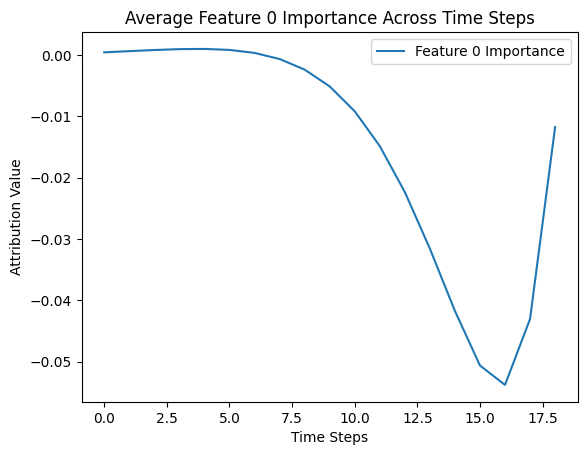

In [76]:
attr_np = attr.cpu().squeeze().detach().numpy()
attr_mean = np.mean(attr_np, axis=0)  # Average over all samples

# Select First Feature
feature_importance = attr_mean[:, 0]  # Select the first feature

# Plot
plt.plot(feature_importance, label="Feature 0 Importance")
plt.xlabel("Time Steps")
plt.ylabel("Attribution Value")
plt.title("Average Feature 0 Importance Across Time Steps")
plt.legend()
plt.show()

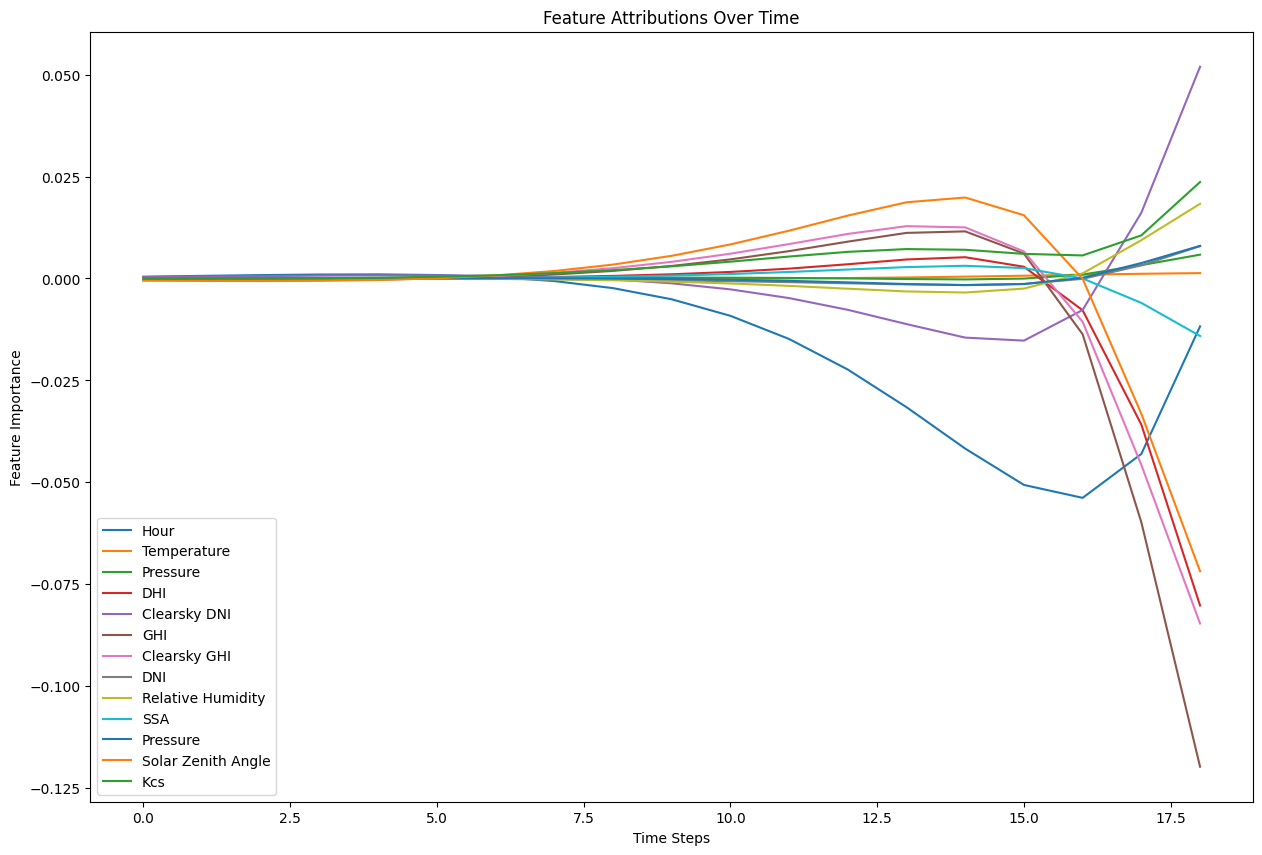

In [77]:
# Convert attributions to NumPy
attr_np = attr.cpu().detach().numpy()
attr_mean = np.mean(attr_np, axis=0)  # Average across samples

plt.figure(figsize=(15, 10))
for i, name in enumerate(colNames):
    plt.plot(attr_mean[:, i], label=name)

plt.xlabel("Time Steps")
plt.ylabel("Feature Importance")
plt.title("Feature Attributions Over Time")
plt.legend()
plt.show()

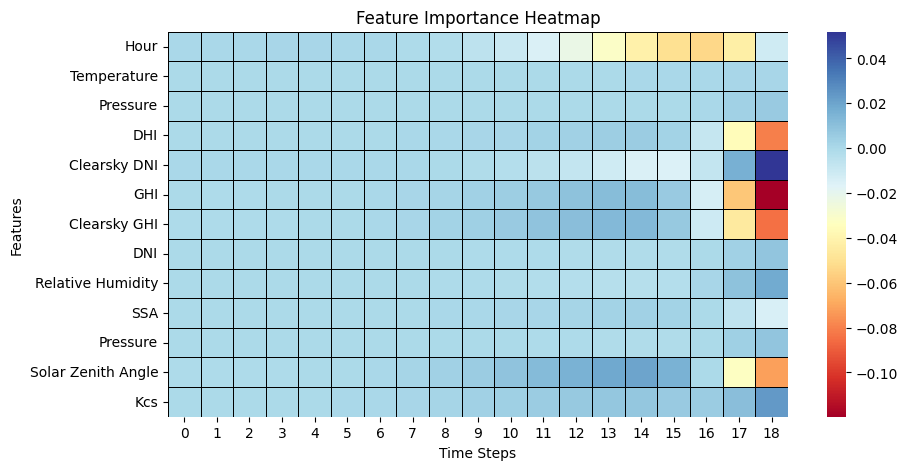

In [75]:
import seaborn as sns
# Plot heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(attr_mean.T, cmap="RdYlBu", linewidths=0.5, linecolor='black', xticklabels=True, yticklabels=colNames)
plt.xlabel("Time Steps")
plt.ylabel("Features")
plt.title("Feature Importance Heatmap")
plt.show()

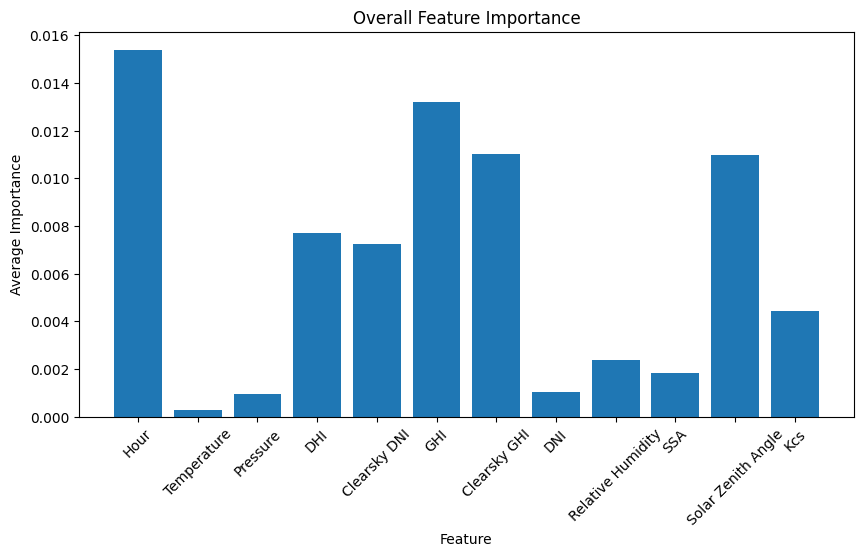

In [70]:
# Compute average importance over all time steps
feature_importance = np.mean(np.abs(attr_mean), axis=0)

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(colNames, feature_importance)
plt.xlabel("Feature")
plt.ylabel("Average Importance")
plt.title("Overall Feature Importance")
plt.xticks(rotation=45)
plt.show()